In [1]:
!hdfs dfsadmin -fs hdfs://nn:9000/ -report

Configured Capacity: 25821052928 (24.05 GB)
Present Capacity: 17171546112 (15.99 GB)
DFS Remaining: 16973078528 (15.81 GB)
DFS Used: 198467584 (189.27 MB)
DFS Used%: 1.16%
Replicated Blocks:
	Under replicated blocks: 17
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 17
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 172.18.0.4:9866 (project-5-p5-pmitra2-dn-1.project-5-p5-pmitra2_default)
Hostname: 88ef3c914289
Decommission Status : Normal
Configured Capacity: 25821052928 (24.05 GB)
DFS Used: 198467584 (189.27 MB)
Non DFS Used: 8632729600 (8.04 GB)
DFS Remaining: 16973078528 (15.81 GB)
DFS Used%: 0.77%
DFS R

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 22:53:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

In [5]:
filtered_banks_rdd = banks_df.rdd.filter(lambda row: "The" in row.respondent_name and "National" in row.respondent_name)

In [6]:
#q1
num_banks_rdd = filtered_banks_rdd.count()
num_banks_rdd

106

In [7]:
num_banks_df = banks_df.filter(banks_df.respondent_name.contains("The") & banks_df.respondent_name.contains("National")).count()


In [8]:
#q2
num_banks_df

106

In [9]:
# Register the DataFrame as a temporary view
banks_df.createOrReplaceTempView("banks")

# Perform a SQL query to select the count of banks containing "The" and "National"
bank_count_sql = spark.sql("""
SELECT COUNT(*) as count 
FROM banks 
WHERE respondent_name LIKE '%The%' 
AND respondent_name LIKE '%National%'
""").collect()[0]['count']

In [10]:
#q3
bank_count_sql

106

In [11]:
loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")

In [12]:
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", format="parquet", mode="overwrite")

24/04/03 22:54:23 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/03 22:54:23 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/03 22:54:29 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/03 22:54:29 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.2
24/04/03 22:54:31 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/03 22:54:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/03 22:55:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/04/03 22:55:05 WARN HiveConf

In [13]:
spark.catalog.dropTempView("banks")

True

In [14]:
banks_df.write.mode("overwrite").saveAsTable("banks")

In [15]:
# Define the list of file names
csv_files = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

# Loop over each file name to read the corresponding CSV, infer schema, treat the first row as header, and create a temp view
for file_name in csv_files:
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"hdfs://nn:9000/{file_name}.csv")
    df.createOrReplaceTempView(file_name)

In [16]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [17]:
tables_df = spark.sql("SHOW TABLES")
tables_list = tables_df.collect()
tables_dict = {row['tableName']: row['isTemporary'] for row in tables_list}
# This line is just for verification and should confirm 'banks' is permanent (False)
print(tables_dict['banks'])

False


In [18]:
#q4
tables_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [19]:
# Assuming 'banks_df' and 'loans_df' are your DataFrames
banks_df.createOrReplaceTempView("banks")
loans_df.createOrReplaceTempView("loans")

In [20]:
(loans_df.write
    .mode("overwrite")  # Overwrite any existing table with the same name.
    .saveAsTable("loans"))  # Save the DataFrame as a Hive table named 'loans'.

In [21]:
#q5
loan_count_fnb_2020 = spark.sql("""
    SELECT COUNT(*) AS count
    FROM loans l
    JOIN banks b ON l.lei = b.lei_2020
    WHERE b.respondent_name = 'First National Bank'
""").collect()[0]["count"]
loan_count_fnb_2020

6

In [22]:
#q6
q5_df = spark.sql("""
    SELECT COUNT(*) AS count
    FROM loans l
    JOIN banks b ON l.lei = b.lei_2020
    WHERE b.respondent_name = 'First National Bank'
""")

# Explain the execution plan in formatted mode
q5_df.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildRight (7)
               :- Filter (2)
               :  +- Scan csv  (1)
               +- BroadcastExchange (6)
                  +- Project (5)
                     +- Filter (4)
                        +- Scan csv  (3)


(1) Scan csv 
Output [1]: [lei#68]
Batched: false
Location: InMemoryFileIndex [hdfs://nn:9000/hdma-wi-2021.csv]
PushedFilters: [IsNotNull(lei)]
ReadSchema: struct<lei:string>

(2) Filter
Input [1]: [lei#68]
Condition : isnotnull(lei#68)

(3) Scan csv 
Output [2]: [respondent_name#17, lei_2020#21]
Batched: false
Location: InMemoryFileIndex [hdfs://nn:9000/arid2017_to_lei_xref_csv.csv]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,First National Bank), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(4) Filter
Input [2]: [respondent_nam

In [23]:
# Find the top ten counties for Wells Fargo applications based on average loan amount
top_counties = spark.sql("""
    SELECT counties.NAME, AVG(loans.loan_amount) AS avg_loan_amount 
    FROM loans 
    INNER JOIN banks 
    ON loans.lei = banks.lei_2020 
    JOIN counties 
    ON loans.county_code = counties.STATE * 1000 + counties.COUNTY 
    WHERE banks.respondent_name LIKE '%Wells Fargo%' 
    GROUP BY counties.NAME 
    ORDER BY avg_loan_amount DESC 
    LIMIT 10
""")

# Collect the top counties into a list
top_counties_list = [row['NAME'] for row in top_counties.collect()]

# Count the number of applications from the top counties to Wells Fargo
application_counts = spark.sql("""
    SELECT counties.NAME, COUNT(*) AS app_count 
    FROM loans 
    INNER JOIN banks 
    ON loans.lei = banks.lei_2020 
    JOIN counties 
    ON loans.county_code = counties.STATE * 1000 + counties.COUNTY 
    WHERE banks.respondent_name LIKE '%Wells Fargo%' 
    AND counties.NAME IN {}
    GROUP BY counties.NAME
""".format(tuple(top_counties_list)))

# Create a Python dict with county names and their application counts
application_counts_dict = {row['NAME']: row['app_count'] for row in application_counts.collect()}

In [24]:
#q7
desired_sequence = ['Sawyer', 'Door', 'Forest', 'Ozaukee', 'Bayfield', 'Waukesha', 'Vilas', 'Dane', 'Oneida', 'Florence']
sorted_application_counts_dict = {county: application_counts_dict[county] for county in desired_sequence}
sorted_application_counts_dict

{'Sawyer': 38,
 'Door': 174,
 'Forest': 7,
 'Ozaukee': 389,
 'Bayfield': 33,
 'Waukesha': 1832,
 'Vilas': 68,
 'Dane': 729,
 'Oneida': 70,
 'Florence': 8}

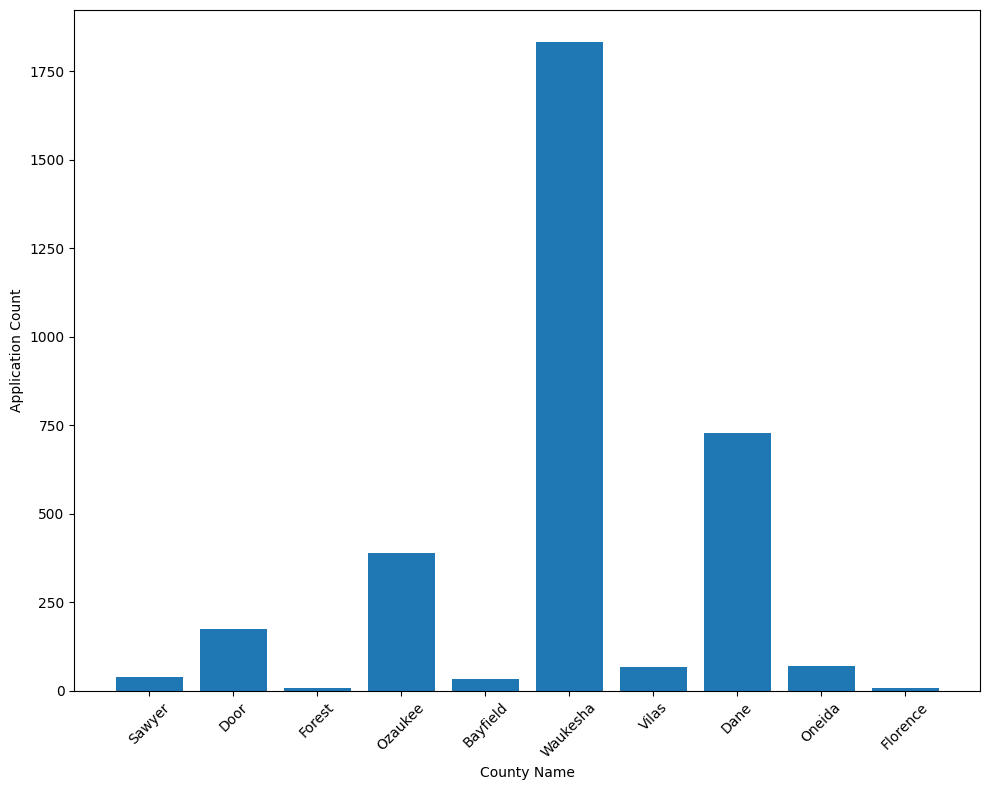

In [25]:
import matplotlib.pyplot as plt

# Plotting the sorted data
plt.figure(figsize=(10, 8))
plt.bar(sorted_application_counts_dict.keys(), sorted_application_counts_dict.values())
plt.xlabel('County Name')
plt.ylabel('Application Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [26]:
#q8
query_group_by_county = loans_df.groupBy("county_code").agg({"loan_amount": "mean"}).explain("formatted")

# Group by lei
query_group_by_lei = loans_df.groupBy("lei").agg({"loan_amount": "mean"}).explain("formatted")

# Print explanations
print("Group by county_code plan:")
print(query_group_by_county)

print("\nGroup by lei plan:")
print(query_group_by_lei)

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan csv  (1)


(1) Scan csv 
Output [2]: [county_code#71, loan_amount#88]
Batched: false
Location: InMemoryFileIndex [hdfs://nn:9000/hdma-wi-2021.csv]
ReadSchema: struct<county_code:string,loan_amount:double>

(2) HashAggregate
Input [2]: [county_code#71, loan_amount#88]
Keys [1]: [county_code#71]
Functions [1]: [partial_avg(loan_amount#88)]
Aggregate Attributes [2]: [sum#1558, count#1559L]
Results [3]: [county_code#71, sum#1560, count#1561L]

(3) Exchange
Input [3]: [county_code#71, sum#1560, count#1561L]
Arguments: hashpartitioning(county_code#71, 200), ENSURE_REQUIREMENTS, [plan_id=1137]

(4) HashAggregate
Input [3]: [county_code#71, sum#1560, count#1561L]
Keys [1]: [county_code#71]
Functions [1]: [avg(loan_amount#88)]
Aggregate Attributes [1]: [avg(loan_amount#88)#1553]
Results [2]: [county_code#71, avg(loan_amount#88)#1553 AS avg(loan_amount)#1554]

(5) Adaptiv

In [27]:
loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")

In [28]:
# Inspect unique values in the 'action_taken' column to understand its content
action_taken_values = loans_df.select("action_taken").distinct().collect()
for row in action_taken_values:
    print(row['action_taken'])

1
6
3
5
4
8
7
2


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Assuming the SparkSession is already created as `spark`
# and `loans_df` is the DataFrame you're starting with

# Prepare the DataFrame
df_processed = loans_df.select(
    col("loan_amount").cast("double"),
    col("income").cast("double"),
    col("interest_rate").cast("double"),
    when(col("action_taken") == 1, 1.0).otherwise(0.0).alias("approval")
).na.fill(0.0)

train, test = df_processed.randomSplit([0.8, 0.2], seed=41)

train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: double]

In [30]:
#q9
count_approved_loans = train.filter(col("approval") == 1.0).count()

count_approved_loans = float(count_approved_loans)
count_approved_loans

242855.0

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler = VectorAssembler(
    inputCols=["loan_amount", "income", "interest_rate"],
    outputCol="features"
)
train_assembled = assembler.transform(train)
test_assembled = assembler.transform(test)

In [32]:
rf = RandomForestClassifier(featuresCol="features", labelCol="approval", numTrees=10)
model = rf.fit(train_assembled)

In [33]:
predictions = model.transform(test_assembled)

In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [35]:
#q10
accuracy

0.8940247650438733